<a href="https://colab.research.google.com/github/AdamStajer07/pytorchTutorial/blob/main/04_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch classification problem

In [1]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.datasets import make_circles

torch.__version__

'2.5.1+cu121'

# 1. Make classification data and get it ready

In [2]:
#Make 1000 samples
n_samples = 1000

#Create circles
X, y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

In [3]:
len(X), len(y), X[:5], y[:5]

(1000,
 1000,
 array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [4]:
#Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


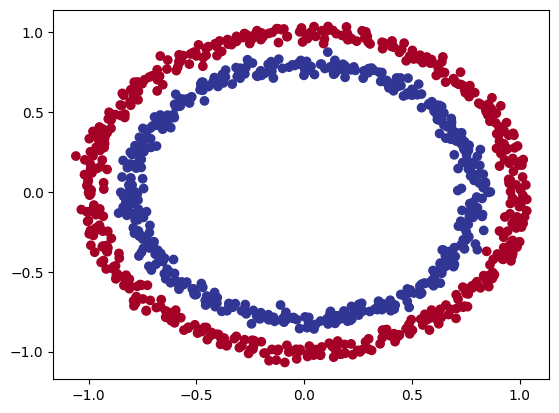

In [5]:
#Visualize
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### 1.1 Check input and output shapes

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Values for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Values for one sample of X: (2,) and the same for y: ()


## 1.2 Turn data into tensors and create train and test splits

In [8]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
type(X)

torch.Tensor

In [10]:
torch.manual_seed(42)

In [11]:
#Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test)

(800, 200)

## 2. Building a model

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

1. Subclasses `nn.Module`
2. Create 2 `nn.Linear()`
3. Defines a `forward()` method
4. Instatiate an instance of our model class and send it to the target `device`

In [14]:
#1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    #2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)


    #self.two_linear_layers = nn.Sequential(
    #  nn.Linear(in_features=2, out_features=5),
    #  nn.Linear(in_features=5, out_features=1)
    #)

  #3. Create a forward() method
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) #x -> layer_1 -> layer_2 -> output
#4. Instatiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
# Let's replicate the model aboce using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),

).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [18]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
  print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
  print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
  print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
  print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

for regression we use MAE or MSE

for classification we use binary cross entropy (BCE) or categorical cross entropy

Optimizer
most common and useful are SGD and Adam

In [19]:
# Setup the loss function
#loss_fn = nn.BCELoss() #requires inputs to have gone through the sigmoid activation function prior to input to BCELoss

loss_fn = nn.BCEWithLogitsLoss() #sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
# Create accuracy - out of 100 examples, what percentage does our model get right
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

we need to build a training loop
1. forward pass
2. calculate the loss
3. optimizer zero grad
4. loss wackward (backpropagation)
5. optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

In [21]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [22]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [23]:
# turn prediction probabilities into prediction labels
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

#Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels))

# Get rid of extra dimension
y_preds.squeeze()

tensor([[ True,  True, False,  True, False],
        [ True,  True, False,  True, False],
        [False, False,  True, False,  True],
        [ True,  True, False,  True, False],
        [False, False,  True, False,  True]], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building and training test loop

In [24]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#Put data to the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  #1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2. Calculate the loss/accuracy
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  #3. Optimizer zero grad
  optimizer.zero_grad()

  #4. Loss backward
  loss.backward()

  #5. Optimizer step
  optimizer.step()


  ###Testing
  model_0.eval()
  with torch.inference_mode():
    #1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. Calculate the test loss/accuracy
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    #Print out what's happenin'
    if epoch % 10 == 0:
      print(f"Epoch: {epoch}| Loss: {loss:.5f}| Acc:{acc:.2f}%| Test loss: {test_loss:.5f}| Test acc: {test_acc:.2f}%")


Epoch: 0| Loss: 0.69796| Acc:51.88%| Test loss: 0.69440| Test acc: 58.00%
Epoch: 10| Loss: 0.69590| Acc:51.25%| Test loss: 0.69305| Test acc: 53.00%
Epoch: 20| Loss: 0.69490| Acc:51.62%| Test loss: 0.69254| Test acc: 49.50%
Epoch: 30| Loss: 0.69435| Acc:51.12%| Test loss: 0.69236| Test acc: 49.50%
Epoch: 40| Loss: 0.69401| Acc:50.88%| Test loss: 0.69232| Test acc: 51.00%
Epoch: 50| Loss: 0.69378| Acc:50.25%| Test loss: 0.69234| Test acc: 50.00%
Epoch: 60| Loss: 0.69362| Acc:50.00%| Test loss: 0.69239| Test acc: 51.50%
Epoch: 70| Loss: 0.69351| Acc:50.25%| Test loss: 0.69246| Test acc: 51.00%
Epoch: 80| Loss: 0.69342| Acc:49.88%| Test loss: 0.69254| Test acc: 50.00%
Epoch: 90| Loss: 0.69336| Acc:49.88%| Test loss: 0.69262| Test acc: 53.00%


## 4. Make predictions and evaluate the model


In [25]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

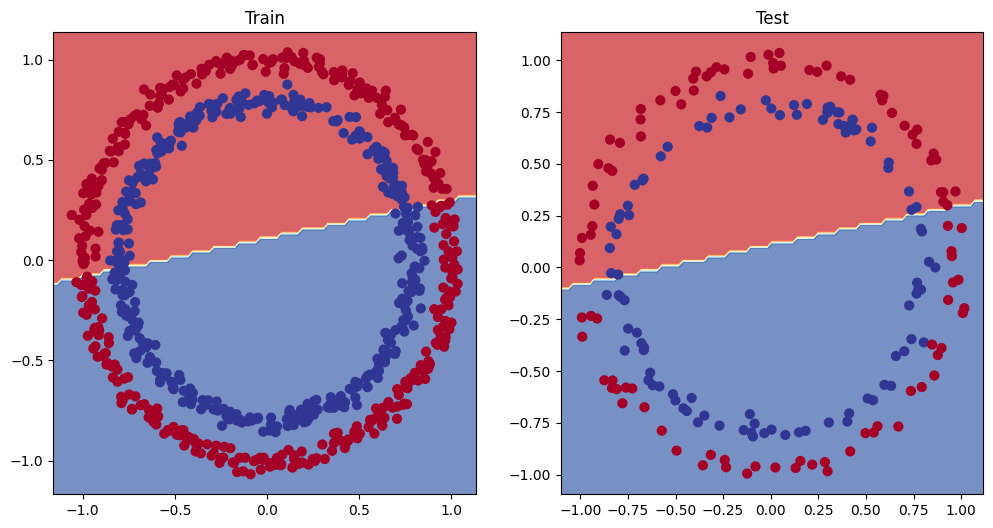

In [26]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)


## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

In [27]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):
    #z = self.layer_1(x)
    #z = self.layer_2(z)
    #z = self.layer_3(z)
    #return z
    return self.layer_3(self.layer_2(self.layer_1(x))) #it's shorter behind the scenes

model_1 = CircleModelV1().to(device)
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [28]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_1.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch}| Loss: {loss:.5f}| Acc: {acc:.2f}% | Test loss: {test_loss:.5}| Test acc: {test_acc:.2f}%")

Epoch: 0| Loss: 0.69396| Acc: 50.88% | Test loss: 0.69261| Test acc: 53.00%
Epoch: 100| Loss: 0.69305| Acc: 50.38% | Test loss: 0.69379| Test acc: 53.00%
Epoch: 200| Loss: 0.69299| Acc: 51.12% | Test loss: 0.69437| Test acc: 53.00%
Epoch: 300| Loss: 0.69298| Acc: 51.62% | Test loss: 0.69458| Test acc: 53.00%
Epoch: 400| Loss: 0.69298| Acc: 51.12% | Test loss: 0.69465| Test acc: 53.00%
Epoch: 500| Loss: 0.69298| Acc: 51.00% | Test loss: 0.69467| Test acc: 53.00%
Epoch: 600| Loss: 0.69298| Acc: 51.00% | Test loss: 0.69468| Test acc: 53.00%
Epoch: 700| Loss: 0.69298| Acc: 51.00% | Test loss: 0.69468| Test acc: 53.00%
Epoch: 800| Loss: 0.69298| Acc: 51.00% | Test loss: 0.69468| Test acc: 53.00%
Epoch: 900| Loss: 0.69298| Acc: 51.00% | Test loss: 0.69468| Test acc: 53.00%


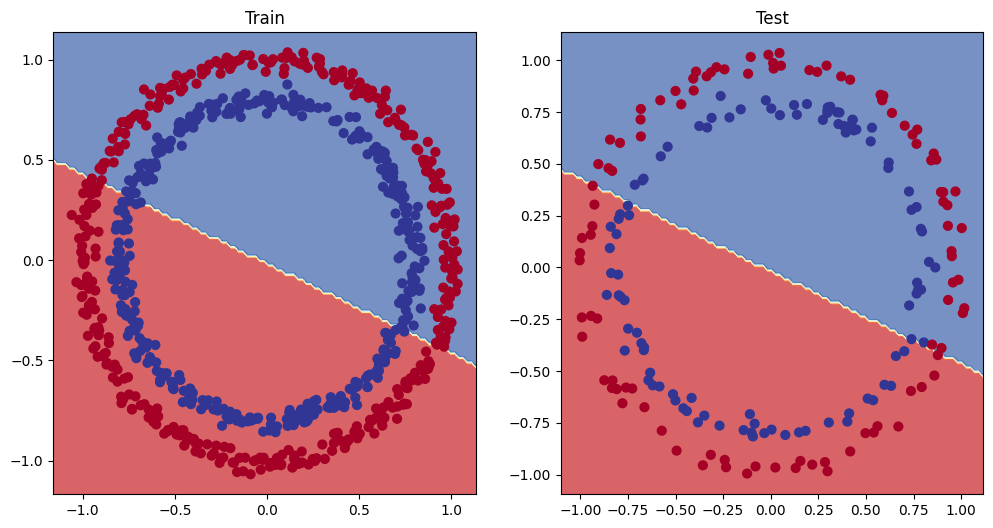

In [30]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)


### 5.1 Preparing data to see if our model can fit a straight line

In [31]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(X_test_regression)

(80, 20)

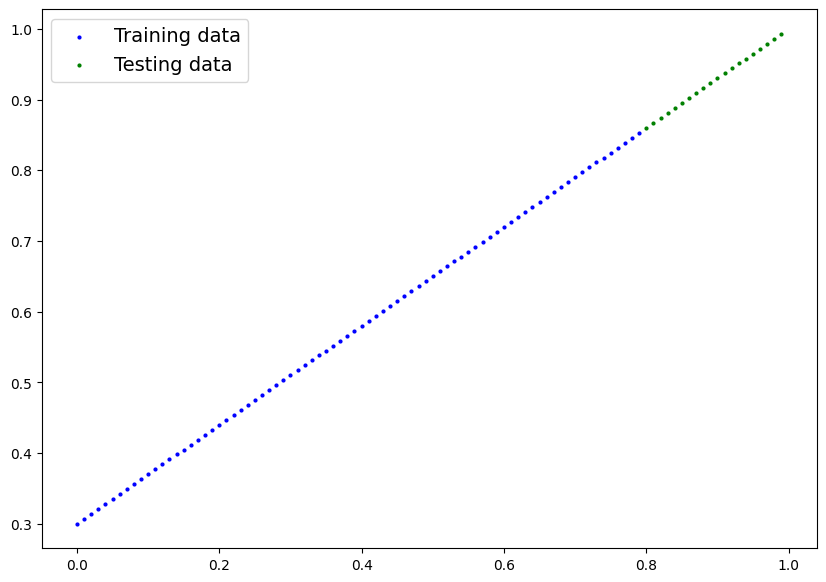

In [32]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

In [33]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [34]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [35]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    y_test_pred = model_2(X_test_regression)
    test_loss = loss_fn(y_test_pred, y_test_regression)

  #if epoch % 100 == 0:
    #print(f"epoch: {epoch}| loss: {loss:.5f}| test loss: {test_loss:.5f}")

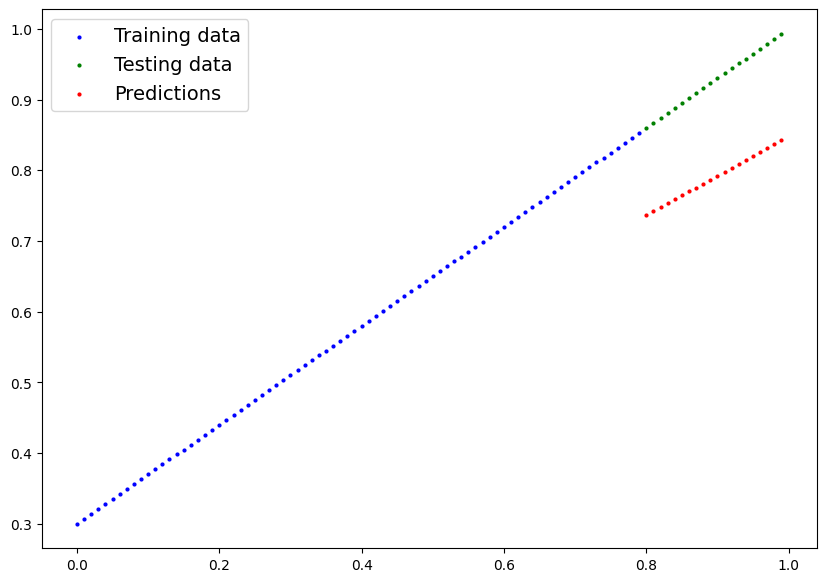

In [36]:
model_2.eval()
with torch.inference_mode():
  y_pred = model_2(X_test_regression)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_pred.cpu())

### 6. Non-linearity

### 6.1 Recreating non-linear data (red and blue circles)

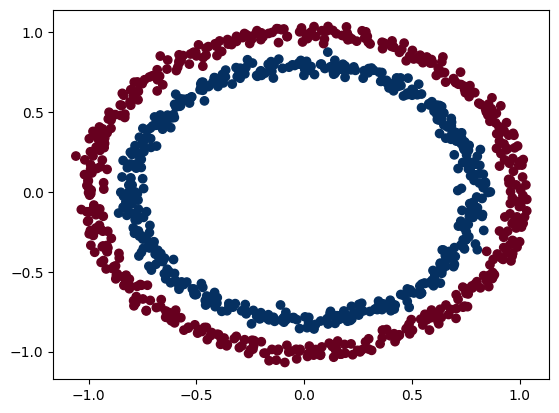

In [37]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [38]:
# Convert data to tensors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

#Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

#Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

### 6.2 Building a model with non-linearity
Linear = straight line

Non-linear = non-straight line

Artificial neural networks are a large combination of linear and non-linear functions which are potentially able to find patterns in data

In [39]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [41]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1500

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    y_test_logits = model_3(X_test).squeeze()
    y_test_pred = torch.round(torch.sigmoid(y_test_logits))
    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=y_test_pred)
    if epoch % 100 == 0:
      print(f"Epoch: {epoch}| Loss: {loss:.5f}| Acc: {acc:.2f}% | Test loss: {test_loss:.5}| Test acc: {test_acc:.2f}%")

Epoch: 0| Loss: 0.69295| Acc: 50.00% | Test loss: 0.69319| Test acc: 50.00%
Epoch: 100| Loss: 0.69115| Acc: 52.88% | Test loss: 0.69102| Test acc: 52.50%
Epoch: 200| Loss: 0.68977| Acc: 53.37% | Test loss: 0.6894| Test acc: 55.00%
Epoch: 300| Loss: 0.68795| Acc: 53.00% | Test loss: 0.68723| Test acc: 56.00%
Epoch: 400| Loss: 0.68517| Acc: 52.75% | Test loss: 0.68411| Test acc: 56.50%
Epoch: 500| Loss: 0.68102| Acc: 52.75% | Test loss: 0.67941| Test acc: 56.50%
Epoch: 600| Loss: 0.67515| Acc: 54.50% | Test loss: 0.67285| Test acc: 56.00%
Epoch: 700| Loss: 0.66659| Acc: 58.38% | Test loss: 0.66322| Test acc: 59.00%
Epoch: 800| Loss: 0.65160| Acc: 64.00% | Test loss: 0.64757| Test acc: 67.50%
Epoch: 900| Loss: 0.62362| Acc: 74.00% | Test loss: 0.62145| Test acc: 79.00%
Epoch: 1000| Loss: 0.56818| Acc: 87.75% | Test loss: 0.57378| Test acc: 86.50%
Epoch: 1100| Loss: 0.48153| Acc: 93.50% | Test loss: 0.49935| Test acc: 90.50%
Epoch: 1200| Loss: 0.37056| Acc: 97.75% | Test loss: 0.40595| Tes

### 6.4 Evaluating a model trained with non-linear activation functions

In [42]:
model_3.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

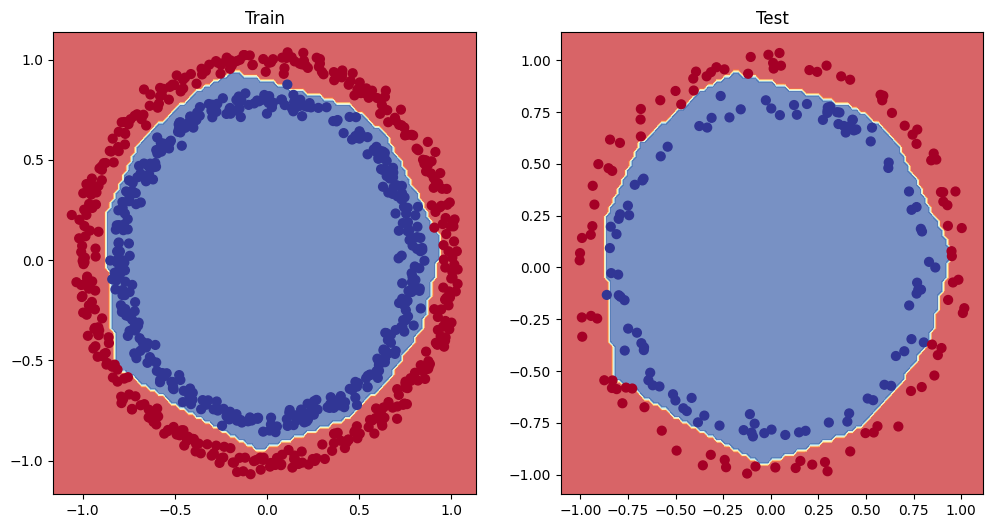

In [43]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

### 7. Replicating non-linear activation functions

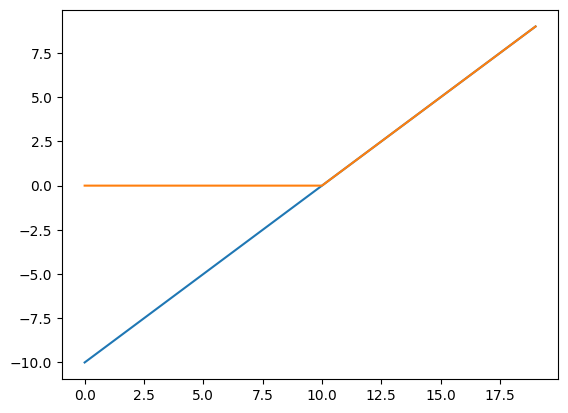

In [44]:
# Crete a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

plt.plot(A)
plt.plot(torch.relu(A))

In [45]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0), x)

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [46]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

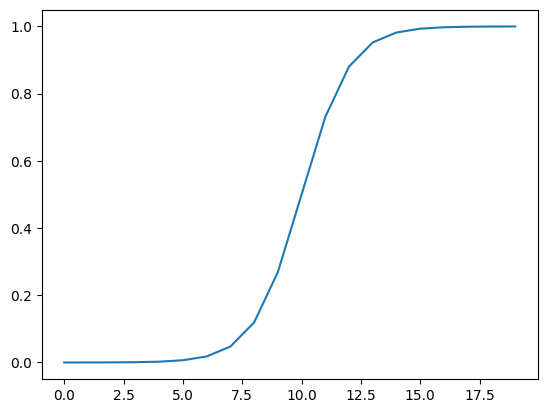

In [47]:
plt.plot(sigmoid(A))

### 8. Putting it all together with a multi-class classification problem

* Binary classification = one thing or another (cat vs. dog, spam vs. not spam ...)
* Multi-class classification = more than one thing or another

## 8.1 Creating a multi-class dataset

(tensor([[-8.4134,  6.9352],
         [-5.7665, -6.4312],
         [-6.0421, -6.7661],
         [ 3.9508,  0.6984],
         [ 4.2505, -0.2815]]),
 tensor([3., 2., 2., 1., 1.]),
 tensor([0., 1., 2., 3.]))

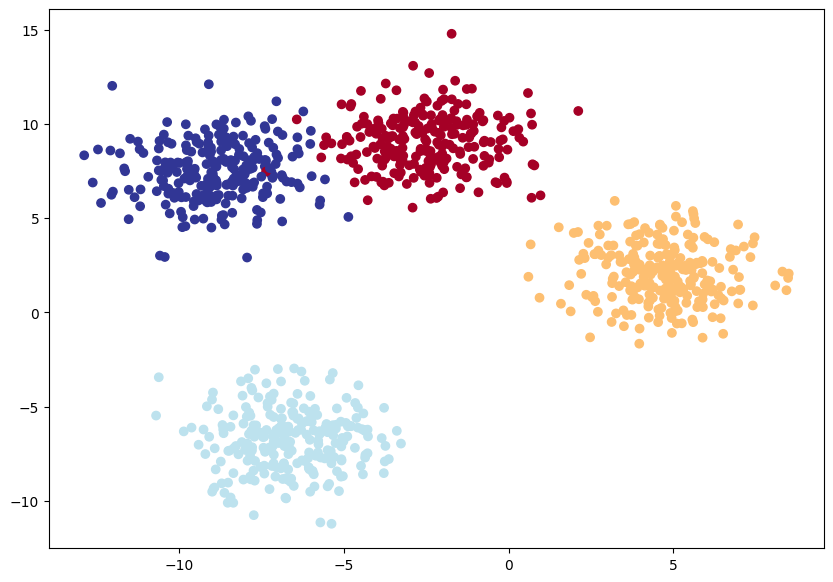

In [59]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.float)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
X_blob[:5], y_blob[:5], torch.unique(y_blob)

## 8.2 Building a multi-class classification model in PyTorch

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [60]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    """
    Initializes all required hyperparameters for a multi-class classification model.
        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Create a loss function and an optimizer for a multi-class classification model

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model_4.parameters(),
                        lr=0.1)

## 8.3 Getting prediction probabilities for a multi-class PyTorch model
Logits -> Pred probs -> Pred labels
- We use softMax instead sigmoid

In [61]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test.to(device))
y_logits[:5]

tensor([[-0.1918,  0.0793, -0.3977,  0.0698],
        [-1.0829,  0.0888, -0.1019, -0.8649],
        [-0.1488,  0.6883,  0.8175,  0.1347],
        [-0.1744,  0.0060, -0.3703,  0.1615],
        [-0.7600,  0.0421, -0.5652, -0.4514]], device='cuda:0')

In [66]:
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))
print(torch.sum(y_pred_probs[0]))

tensor([0.2260, 0.2964, 0.1840, 0.2936], device='cuda:0')
tensor(1, device='cuda:0')
tensor(1., device='cuda:0')


In [67]:
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 1, 2, 3, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2,
        2, 1, 1, 1, 3, 1, 1, 3, 3, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 3, 3,
        1, 1, 3, 1, 3, 3, 1, 2, 3, 3, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 2, 3, 3, 1, 2, 2, 1, 1, 1, 3, 2,
        2, 1, 1, 3, 2, 1, 1, 1, 2, 1, 3, 2, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 2, 2,
        2, 1, 1, 1, 1, 2, 2, 3, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1,
        2, 2, 1, 1, 1, 3, 3, 3, 1, 3, 1, 1, 1, 2, 2, 3, 2, 2, 1, 3, 2, 2, 1, 1,
        3, 1, 2, 1, 1, 3, 2, 1], device='cuda:0')

In [78]:
y_blob_test

tensor([1., 3., 2., 1., 0., 3., 2., 0., 2., 0., 0., 1., 0., 0., 0., 3., 3., 2.,
        3., 3., 3., 0., 1., 2., 2., 2., 3., 0., 1., 0., 3., 1., 1., 3., 1., 2.,
        1., 3., 0., 2., 0., 3., 3., 2., 0., 3., 1., 1., 0., 3., 1., 0., 1., 1.,
        3., 2., 1., 1., 3., 2., 2., 0., 3., 2., 2., 0., 0., 3., 3., 0., 0., 3.,
        3., 3., 2., 3., 3., 3., 3., 1., 0., 2., 3., 2., 3., 3., 2., 3., 3., 2.,
        3., 3., 1., 3., 3., 3., 1., 0., 3., 2., 0., 0., 3., 0., 2., 3., 1., 0.,
        3., 2., 1., 1., 0., 2., 2., 3., 0., 0., 1., 2., 2., 3., 0., 1., 2., 0.,
        0., 0., 2., 3., 1., 2., 3., 2., 0., 3., 0., 0., 1., 1., 1., 0., 2., 2.,
        2., 2., 0., 3., 3., 2., 2., 1., 3., 2., 0., 0., 3., 3., 2., 1., 2., 0.,
        3., 2., 0., 3., 2., 0., 2., 2., 2., 0., 3., 1., 1., 1., 1., 1., 3., 1.,
        0., 2., 2., 1., 2., 2., 0., 1., 2., 2., 0., 0., 1., 3., 2., 0., 3., 1.,
        2., 1.])

## 8.5 Creating a training loop and testing loop for a multi-class PyTorch model